# Predict Probability of Default
##### Author: Stefanie Garises

Assuming a recovery rate of 10%, this can be used to givessthe expected loss on a loan.

* You should produce a function that can take in the properties of a loan and output the expected loss.
* You can explore any technique ranging from a simple regression or a decision tree to something more advanced. You can also use multiple methods and provide a comparative analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import linear_model
import scipy.stats as stat
%matplotlib inline
sns.set()

In [2]:
# Import data from csv file
loan_data = pd.read_csv("input/Customer_Loan_Data.csv")
loan_data.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


## Data Enrichment

In [3]:
# Create descriptive labels for fico scores
desc = []

for i in range(0, len(loan_data["fico_score"])):
    #print("index: " + str(i))
    if (300 <= loan_data["fico_score"][i] <= 570):
        desc.append("Poor")
    elif (571 <= loan_data["fico_score"][i] <= 669):
        desc.append("Fair")
    elif (670 <= loan_data["fico_score"][i] <= 739):
        desc.append("Good")
    elif (740 <= loan_data["fico_score"][i] <= 799):
        desc.append("Very Good")
    elif (800 <= loan_data["fico_score"][i] <= 850):
        desc.append("Excellent")

desc

['Fair',
 'Fair',
 'Fair',
 'Fair',
 'Fair',
 'Good',
 'Good',
 'Poor',
 'Good',
 'Poor',
 'Fair',
 'Fair',
 'Poor',
 'Fair',
 'Fair',
 'Fair',
 'Fair',
 'Good',
 'Fair',
 'Fair',
 'Fair',
 'Poor',
 'Good',
 'Good',
 'Fair',
 'Fair',
 'Fair',
 'Fair',
 'Fair',
 'Fair',
 'Fair',
 'Good',
 'Poor',
 'Fair',
 'Very Good',
 'Good',
 'Fair',
 'Poor',
 'Poor',
 'Fair',
 'Fair',
 'Very Good',
 'Poor',
 'Fair',
 'Poor',
 'Fair',
 'Fair',
 'Good',
 'Fair',
 'Very Good',
 'Good',
 'Very Good',
 'Fair',
 'Fair',
 'Good',
 'Fair',
 'Good',
 'Fair',
 'Good',
 'Good',
 'Poor',
 'Good',
 'Fair',
 'Fair',
 'Fair',
 'Good',
 'Fair',
 'Very Good',
 'Fair',
 'Poor',
 'Fair',
 'Very Good',
 'Fair',
 'Good',
 'Fair',
 'Fair',
 'Fair',
 'Fair',
 'Good',
 'Fair',
 'Fair',
 'Fair',
 'Good',
 'Fair',
 'Poor',
 'Fair',
 'Very Good',
 'Fair',
 'Good',
 'Fair',
 'Very Good',
 'Good',
 'Good',
 'Good',
 'Fair',
 'Poor',
 'Good',
 'Fair',
 'Fair',
 'Fair',
 'Fair',
 'Fair',
 'Fair',
 'Fair',
 'Good',
 'Fair',
 'Poor

In [4]:
loan_data["rating"] = desc
loan_data.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default,rating
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0,Fair
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1,Fair
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0,Fair
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0,Fair
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0,Fair


## EDA

In [5]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10000 non-null  int64  
 1   credit_lines_outstanding  10000 non-null  int64  
 2   loan_amt_outstanding      10000 non-null  float64
 3   total_debt_outstanding    10000 non-null  float64
 4   income                    10000 non-null  float64
 5   years_employed            10000 non-null  int64  
 6   fico_score                10000 non-null  int64  
 7   default                   10000 non-null  int64  
 8   rating                    10000 non-null  object 
dtypes: float64(3), int64(5), object(1)
memory usage: 703.3+ KB


In [6]:
loan_data["rating"].unique()

array(['Fair', 'Good', 'Poor', 'Very Good', 'Excellent'], dtype=object)

In [7]:
loan_data["rating"].value_counts()

rating
Fair         5653
Good         2588
Poor         1328
Very Good     397
Excellent      34
Name: count, dtype: int64

In [8]:
loan_data["rating"].value_counts()/loan_data["rating"].count()

rating
Fair         0.5653
Good         0.2588
Poor         0.1328
Very Good    0.0397
Excellent    0.0034
Name: count, dtype: float64

In [9]:
# Check proportion of defaults
loan_data["default"].value_counts()/loan_data["default"].count()

default
0    0.8149
1    0.1851
Name: count, dtype: float64

## Split Dataset

In [10]:
# Remove the default column and split the dataset for training and testing
loan_data_inputs_train, loan_data_inputs_test, loan_data_targets_train, loan_data_targets_test = train_test_split(loan_data.drop('default', axis = 1), loan_data['default'], test_size = 0.2, random_state = 31)

In [11]:
loan_data_inputs_train.shape

(8000, 8)

In [12]:
loan_data_inputs_test.shape

(2000, 8)

In [13]:
loan_data_targets_train.shape

(8000,)

In [14]:
loan_data_targets_test.shape

(2000,)

## Data Preparation

In [15]:
df_inputs_prepr = loan_data_inputs_test
df_targets_prepr = loan_data_targets_test

In [16]:
df_inputs_prepr["rating"].unique()

array(['Fair', 'Good', 'Poor', 'Very Good', 'Excellent'], dtype=object)

### Preprocessing

#### Discrete Variables

##### Weight of Evidence
$$ WoE_{j} = ln(\frac{Percent Good_{j}}{Percent Bad_{j}}) $$

##### Information Value
$$ IV = \sum_{j=1}^{K} (Percent Good_{j} - Percent Bad_{j}) * WoE_{j} $$

In [17]:
# Define Weight of Evidence Function
def woe_discrete(df, discrete_variable_name, outcome_variable_df):
    # Isolate independent variable and target variable
    df = pd.concat([df[discrete_variable_name], outcome_variable_df], axis = 1)
    # Get proportions of default per category
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(), 
                 df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    # Drop one of the duplicate category columns
    df = df.iloc[:,[0,1,3]]
    # Rename duplicate columns
    df.columns = [df.columns.values[0], 'default_obs', 'default_prop']
    # Get proportion of observations
    df["obs_prop"] = df["default_obs"] / df["default_obs"].sum()
    # Calculate number of defaulters and non-defaulters by category group
    df["n_default"] = df["default_prop"] * df["default_obs"]
    df["n_no_default"] = (1 - df["default_prop"]) * df["default_obs"]
    # Calculate proportions of defaulters and non-defaulters by rating group
    df["prop_n_default"] = df["n_default"] / df["n_default"].sum()
    df["prop_n_no_default"] = df["n_no_default"] / df["n_no_default"].sum()
    # Calculate weight of evidence
    df["WoE"] = np.log(df["prop_n_default"] / df["prop_n_no_default"])
    # Replace NaN and negative infinity values
    df.replace([np.nan, -np.inf, np.inf], [0,-2,2], inplace = True)
    # Sort df to see highest default rates first
    df = df.sort_values(["WoE"])
    df = df.reset_index(drop = True)
    # Calculate difference between each two subsequent rows
    df["diff_prop_default"] = df["default_prop"].diff().abs()
    df["diff_WoE"] = df["WoE"].diff().abs()
    # Calculate Information Value
    df["IV"] = (df["prop_n_default"] - df["prop_n_no_default"]) * df["WoE"]
    df["IV"] = df["IV"].sum()

    return df

In [18]:
# Test the function
df_temp = woe_discrete(df_inputs_prepr, 'rating', df_targets_prepr)
df_temp

,rating,default_obs,default_prop,obs_prop,n_default,n_no_default,prop_n_default,prop_n_no_default,WoE,diff_prop_default,diff_WoE,IV
0,Very Good,74,0.013514,0.0370,1.0,73.0,0.002793,0.044458,-2.767322,NaN,NaN,0.698181
1,Good,549,0.065574,0.2745,36.0,513.0,0.100559,0.312424,-1.133620,0.052060,1.633703,0.698181
2,Excellent,9,0.111111,0.0045,1.0,8.0,0.002793,0.004872,-0.556304,0.045537,0.577315,0.698181
3,Fair,1127,0.182786,0.5635,206.0,921.0,0.575419,0.560901,0.025553,0.071675,0.581858,0.698181
4,Poor,241,0.473029,0.1205,114.0,127.0,0.318436,0.077345,1.415149,0.290243,1.389595,0.698181


#### Create Plotting Method to Visualise Results

In [19]:
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    # Convert categories to labels and resulting series to an array for ease of plotting
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    y = df_WoE["WoE"]
    # Define the plot size
    plt.figure(figsize = (18, 6))
    # Plot the data
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels)

#### Create Dummy Variables

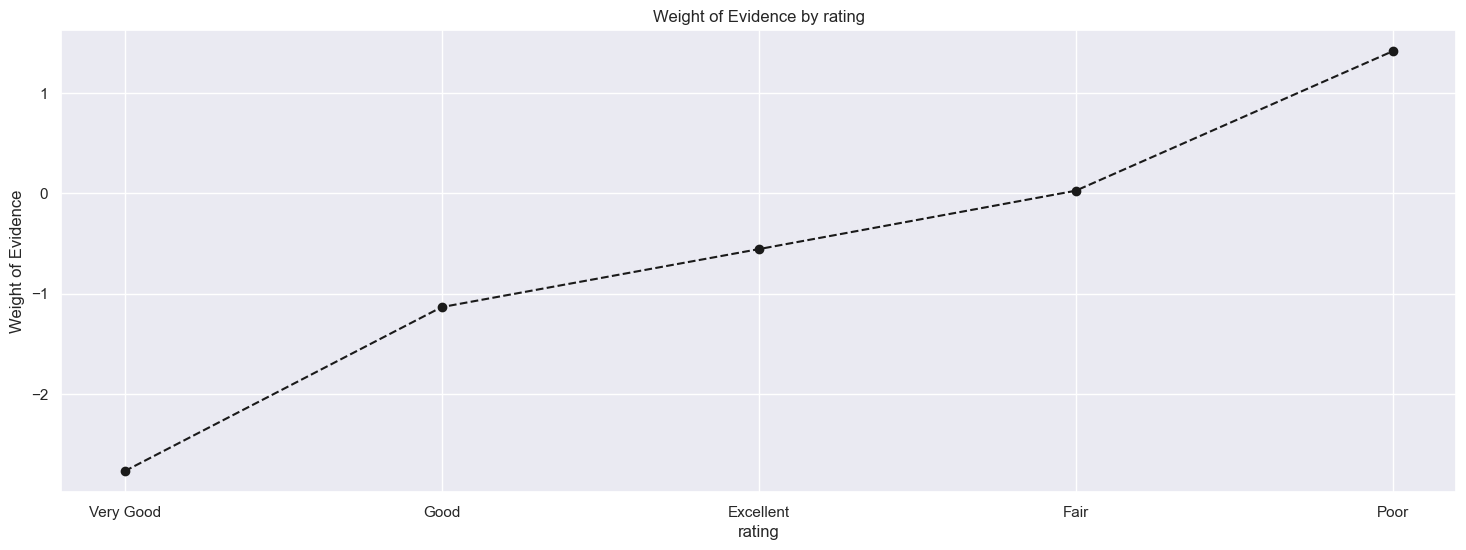

In [20]:
plot_by_woe(df_temp)

In [21]:
# Create dummy variables for ratings
df_inputs_prepr['fico_rating: Poor'] = np.where(df_inputs_prepr['rating'].isin(['Poor']), 1, 0)
df_inputs_prepr['fico_rating: Fair'] = np.where(df_inputs_prepr['rating'].isin(['Fair']), 1, 0)
df_inputs_prepr['fico_rating: Good'] = np.where(df_inputs_prepr['rating'].isin(['Good']), 1, 0)
df_inputs_prepr['fico_rating: Very Good'] = np.where(df_inputs_prepr['rating'].isin(['Very Good']), 1, 0)
df_inputs_prepr['fico_rating: Excellent'] = np.where(df_inputs_prepr['rating'].isin(['Excellent']), 1, 0)
df_inputs_prepr.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,rating,fico_rating: Poor,fico_rating: Fair,fico_rating: Good,fico_rating: Very Good,fico_rating: Excellent
757,1798608,1,2925.513567,5441.242839,67458.06326,5,596,Fair,0,1,0,0,0
1003,5836331,5,3791.984312,17150.110870,60086.64313,3,654,Fair,0,1,0,0,0
8089,5009650,0,2587.675297,2842.843402,50216.01953,5,651,Fair,0,1,0,0,0
2967,5705345,3,3605.773746,13412.754690,66082.40040,4,656,Fair,0,1,0,0,0
5011,6465413,5,5048.182840,23140.381640,86206.73017,7,671,Good,0,0,1,0,0


#### Continuous Variables

In [22]:
loan_data.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default,rating
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0,Fair
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1,Fair
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0,Fair
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0,Fair
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0,Fair


In [23]:
# Define Weight of Evidence Function
def woe_ordered_continuous(df, discrete_variable_name, outcome_variable_df):
    # Isolate independent variable and target variable
    df = pd.concat([df[discrete_variable_name], outcome_variable_df], axis = 1)
    # Get proportions of default per category
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(), 
                 df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    # Drop one of the duplicate category columns
    df = df.iloc[:,[0,1,3]]
    # Rename duplicate columns
    df.columns = [df.columns.values[0], 'default_obs', 'default_prop']
    # Get proportion of observations
    df["obs_prop"] = df["default_obs"] / df["default_obs"].sum()
    # Calculate number of defaulters and non-defaulters by category group
    df["n_default"] = df["default_prop"] * df["default_obs"]
    df["n_no_default"] = (1 - df["default_prop"]) * df["default_obs"]
    # Calculate proportions of defaulters and non-defaulters by rating group
    df["prop_n_default"] = df["n_default"] / df["n_default"].sum()
    df["prop_n_no_default"] = df["n_no_default"] / df["n_no_default"].sum()
    # Calculate weight of evidence
    df["WoE"] = np.log(df["prop_n_default"] / df["prop_n_no_default"])
    # Replace NaN and negative infinity values
    df.replace([np.nan, -np.inf, np.inf], [0,-2,2], inplace = True)
    # Preserve natural order of data
    #df = df.sort_values(["WoE"])
    #df = df.reset_index(drop = True)
    # Calculate difference between each two subsequent rows
    df["diff_prop_default"] = df["default_prop"].diff().abs()
    df["diff_WoE"] = df["WoE"].diff().abs()
    # Calculate Information Value
    df["IV"] = (df["prop_n_default"] - df["prop_n_no_default"]) * df["WoE"]
    df["IV"] = df["IV"].sum()

    return df

In [24]:
# Test the function
df_temp = woe_ordered_continuous(df_inputs_prepr, 'years_employed', df_targets_prepr)
df_temp

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,years_employed,default_obs,default_prop,obs_prop,n_default,n_no_default,prop_n_default,prop_n_no_default,WoE,diff_prop_default,diff_WoE,IV
0,0,9,0.666667,0.0045,6.0,3.0,0.016760,0.001827,2.216284,NaN,NaN,0.619746
1,1,28,0.571429,0.0140,16.0,12.0,0.044693,0.007308,1.810819,0.095238,0.405465,0.619746
2,2,151,0.251656,0.0755,38.0,113.0,0.106145,0.068819,0.433336,0.319773,1.377484,0.619746
3,3,351,0.279202,0.1755,98.0,253.0,0.273743,0.154080,0.574715,0.027547,0.141380,0.619746
4,4,427,0.241218,0.2135,103.0,324.0,0.287709,0.197320,0.377123,0.037984,0.197593,0.619746
5,5,499,0.146293,0.2495,73.0,426.0,0.203911,0.259440,-0.240843,0.094925,0.617965,0.619746
6,6,327,0.051988,0.1635,17.0,310.0,0.047486,0.188794,-1.380222,0.094305,1.139379,0.619746
7,7,142,0.028169,0.0710,4.0,138.0,0.011173,0.084044,-2.017822,0.023819,0.637600,0.619746
8,8,57,0.052632,0.0285,3.0,54.0,0.008380,0.032887,-1.367234,0.024463,0.650588,0.619746
9,9,8,0.000000,0.0040,0.0,8.0,0.000000,0.004872,-2.000000,0.052632,0.632766,0.619746


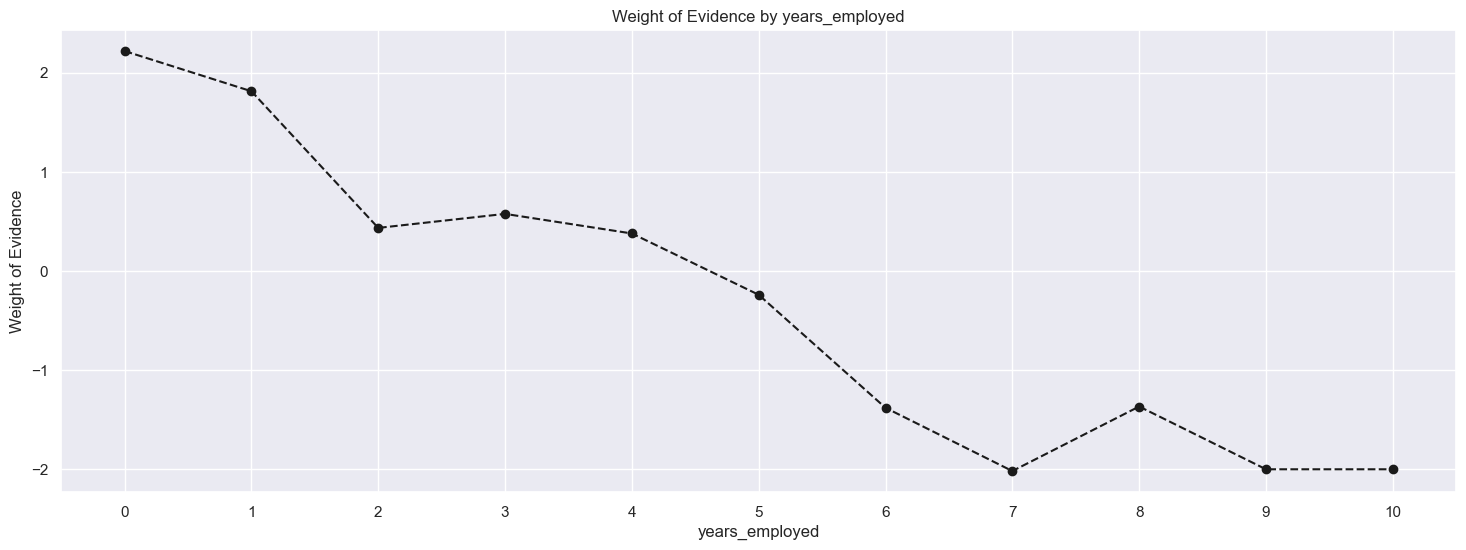

In [25]:
plot_by_woe(df_temp)

In [26]:
# Create dummy variables for years_employed variable
df_inputs_prepr['tenure: 0'] = np.where(df_inputs_prepr['years_employed'].isin([0]), 1, 0)
df_inputs_prepr['tenure: 1'] = np.where(df_inputs_prepr['years_employed'].isin([1]), 1, 0)
df_inputs_prepr['tenure: 2-4'] = np.where(df_inputs_prepr['years_employed'].isin(range(2,5)), 1, 0)
df_inputs_prepr['tenure: 5-6'] = np.where(df_inputs_prepr['years_employed'].isin(range(5,7)), 1, 0)
df_inputs_prepr['tenure: 7-9'] = np.where(df_inputs_prepr['years_employed'].isin(range(7,10)), 1, 0)
df_inputs_prepr['tenure: 10+'] = np.where(df_inputs_prepr['years_employed'].isin(range(10,60)), 1, 0)
df_inputs_prepr.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,rating,fico_rating: Poor,fico_rating: Fair,fico_rating: Good,fico_rating: Very Good,fico_rating: Excellent,tenure: 0,tenure: 1,tenure: 2-4,tenure: 5-6,tenure: 7-9,tenure: 10+
757,1798608,1,2925.513567,5441.242839,67458.06326,5,596,Fair,0,1,0,0,0,0,0,0,1,0,0
1003,5836331,5,3791.984312,17150.110870,60086.64313,3,654,Fair,0,1,0,0,0,0,0,1,0,0,0
8089,5009650,0,2587.675297,2842.843402,50216.01953,5,651,Fair,0,1,0,0,0,0,0,0,1,0,0
2967,5705345,3,3605.773746,13412.754690,66082.40040,4,656,Fair,0,1,0,0,0,0,0,1,0,0,0
5011,6465413,5,5048.182840,23140.381640,86206.73017,7,671,Good,0,0,1,0,0,0,0,0,0,1,0


In [27]:
# Create categories for income variable
#df_inputs_prepr['income'] = pd.cut(df_inputs_prepr['income'], 20)
#df_inputs_prepr

In [28]:
#df_temp = woe_ordered_continuous(df_inputs_prepr, 'income', df_targets_prepr)
#df_temp

In [29]:
#plot_by_woe(df_temp, 90)

In [30]:
# Create dummy variables for income variable
df_inputs_prepr['income: 0-30000'] = np.where(df_inputs_prepr['income'].isin(range(0,30001)), 1, 0)
df_inputs_prepr['income: 30001-45000'] = np.where(df_inputs_prepr['income'].isin(range(30001,45001)), 1, 0)
df_inputs_prepr['income: 45001-52000'] = np.where(df_inputs_prepr['income'].isin(range(45001,52001)), 1, 0)
df_inputs_prepr['income: 52001-59000'] = np.where(df_inputs_prepr['income'].isin(range(52001,59001)), 1, 0)
df_inputs_prepr['income: 59001-67000'] = np.where(df_inputs_prepr['income'].isin(range(59001,67001)), 1, 0)
df_inputs_prepr['income: 67001-75000'] = np.where(df_inputs_prepr['income'].isin(range(67001,75001)), 1, 0)
df_inputs_prepr['income: 75001-82000'] = np.where(df_inputs_prepr['income'].isin(range(75001,82001)), 1, 0)
df_inputs_prepr['income: 82001-89000'] = np.where(df_inputs_prepr['income'].isin(range(82001,89001)), 1, 0)
df_inputs_prepr['income: 89001-97000'] = np.where(df_inputs_prepr['income'].isin(range(89001,97001)), 1, 0)
df_inputs_prepr['income: 97001-118000'] = np.where(df_inputs_prepr['income'].isin(range(97001,118001)), 1, 0)
df_inputs_prepr['income: 118001+'] = np.where(df_inputs_prepr['income'].isin(range(118001,1000000)), 1, 0)
df_inputs_prepr.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,rating,fico_rating: Poor,fico_rating: Fair,...,income: 30001-45000,income: 45001-52000,income: 52001-59000,income: 59001-67000,income: 67001-75000,income: 75001-82000,income: 82001-89000,income: 89001-97000,income: 97001-118000,income: 118001+
757,1798608,1,2925.513567,5441.242839,67458.06326,5,596,Fair,0,1,...,0,0,0,0,0,0,0,0,0,0
1003,5836331,5,3791.984312,17150.110870,60086.64313,3,654,Fair,0,1,...,0,0,0,0,0,0,0,0,0,0
8089,5009650,0,2587.675297,2842.843402,50216.01953,5,651,Fair,0,1,...,0,0,0,0,0,0,0,0,0,0
2967,5705345,3,3605.773746,13412.754690,66082.40040,4,656,Fair,0,1,...,0,0,0,0,0,0,0,0,0,0
5011,6465413,5,5048.182840,23140.381640,86206.73017,7,671,Good,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
# Create categories for loan_amt_outstanding variable
#df_inputs_prepr['loan_amt_outstanding'] = pd.cut(df_inputs_prepr['loan_amt_outstanding'], 10)
#df_inputs_prepr

In [32]:
df_temp = woe_ordered_continuous(df_inputs_prepr, 'loan_amt_outstanding', df_targets_prepr)
df_temp

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,loan_amt_outstanding,default_obs,default_prop,obs_prop,n_default,n_no_default,prop_n_default,prop_n_no_default,WoE,diff_prop_default,diff_WoE,IV
0,50.203718,1,0.0,0.0005,0.0,1.0,0.000000,0.000609,-2.0,NaN,NaN,4.0
1,57.348647,1,0.0,0.0005,0.0,1.0,0.000000,0.000609,-2.0,0.0,0.0,4.0
2,598.524269,1,1.0,0.0005,1.0,0.0,0.002793,0.000000,2.0,1.0,4.0,4.0
3,664.262243,1,1.0,0.0005,1.0,0.0,0.002793,0.000000,2.0,0.0,0.0,4.0
4,680.820274,1,0.0,0.0005,0.0,1.0,0.000000,0.000609,-2.0,1.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,8802.265206,1,1.0,0.0005,1.0,0.0,0.002793,0.000000,2.0,1.0,4.0,4.0
1996,8887.820215,1,0.0,0.0005,0.0,1.0,0.000000,0.000609,-2.0,1.0,4.0,4.0
1997,9169.497900,1,0.0,0.0005,0.0,1.0,0.000000,0.000609,-2.0,0.0,0.0,4.0
1998,9351.882044,1,0.0,0.0005,0.0,1.0,0.000000,0.000609,-2.0,0.0,0.0,4.0


In [33]:
#plot_by_woe(df_temp, 90)

In [34]:
# Create dummy variables for loan_amt_outstanding variable
df_inputs_prepr['lao: 0-36'] = np.where(df_inputs_prepr['loan_amt_outstanding'].isin(range(0,36)), 1, 0)
df_inputs_prepr['lao: 36-1700'] = np.where(df_inputs_prepr['loan_amt_outstanding'].isin(range(36,1701)), 1, 0)
df_inputs_prepr['lao: 1701-4400'] = np.where(df_inputs_prepr['loan_amt_outstanding'].isin(range(1701,4401)), 1, 0)
df_inputs_prepr['lao: 4401-7500'] = np.where(df_inputs_prepr['loan_amt_outstanding'].isin(range(4401,7501)), 1, 0)
df_inputs_prepr['lao: 7501-9700'] = np.where(df_inputs_prepr['loan_amt_outstanding'].isin(range(7501,9701)), 1, 0)
df_inputs_prepr['lao: 9701-10700'] = np.where(df_inputs_prepr['loan_amt_outstanding'].isin(range(9701,10701)), 1, 0)
df_inputs_prepr['lao: 10701+'] = np.where(df_inputs_prepr['loan_amt_outstanding'].isin(range(10701,1000000)), 1, 0)
df_inputs_prepr.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,rating,fico_rating: Poor,fico_rating: Fair,...,income: 89001-97000,income: 97001-118000,income: 118001+,lao: 0-36,lao: 36-1700,lao: 1701-4400,lao: 4401-7500,lao: 7501-9700,lao: 9701-10700,lao: 10701+
757,1798608,1,2925.513567,5441.242839,67458.06326,5,596,Fair,0,1,...,0,0,0,0,0,0,0,0,0,0
1003,5836331,5,3791.984312,17150.110870,60086.64313,3,654,Fair,0,1,...,0,0,0,0,0,0,0,0,0,0
8089,5009650,0,2587.675297,2842.843402,50216.01953,5,651,Fair,0,1,...,0,0,0,0,0,0,0,0,0,0
2967,5705345,3,3605.773746,13412.754690,66082.40040,4,656,Fair,0,1,...,0,0,0,0,0,0,0,0,0,0
5011,6465413,5,5048.182840,23140.381640,86206.73017,7,671,Good,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
# Create categories for credit_lines_outstanding variable
#df_inputs_prepr['credit_lines_outstanding'] = pd.cut(df_inputs_prepr['credit_lines_outstanding'], 10)
#df_inputs_prepr

In [36]:
#df_temp = woe_ordered_continuous(df_inputs_prepr, 'credit_lines_outstanding', df_targets_prepr)
#df_temp

In [37]:
#plot_by_woe(df_temp, 90)

In [38]:
# Create dummy variables for credit_lines_outstanding variable depending on numbber of observations and WoE
df_inputs_prepr['clo: 0'] = np.where(df_inputs_prepr['credit_lines_outstanding'].isin([0]), 1, 0)
df_inputs_prepr['clo: 1'] = np.where(df_inputs_prepr['credit_lines_outstanding'].isin([1]), 1, 0)
df_inputs_prepr['clo: 2'] = np.where(df_inputs_prepr['credit_lines_outstanding'].isin([2]), 1, 0)
df_inputs_prepr['clo: 3'] = np.where(df_inputs_prepr['credit_lines_outstanding'].isin([3]), 1, 0)
df_inputs_prepr['clo: 4'] = np.where(df_inputs_prepr['credit_lines_outstanding'].isin([4]), 1, 0)
df_inputs_prepr['clo: 5'] = np.where(df_inputs_prepr['credit_lines_outstanding'].isin([5]), 1, 0)
df_inputs_prepr.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,rating,fico_rating: Poor,fico_rating: Fair,...,lao: 4401-7500,lao: 7501-9700,lao: 9701-10700,lao: 10701+,clo: 0,clo: 1,clo: 2,clo: 3,clo: 4,clo: 5
757,1798608,1,2925.513567,5441.242839,67458.06326,5,596,Fair,0,1,...,0,0,0,0,0,1,0,0,0,0
1003,5836331,5,3791.984312,17150.110870,60086.64313,3,654,Fair,0,1,...,0,0,0,0,0,0,0,0,0,1
8089,5009650,0,2587.675297,2842.843402,50216.01953,5,651,Fair,0,1,...,0,0,0,0,1,0,0,0,0,0
2967,5705345,3,3605.773746,13412.754690,66082.40040,4,656,Fair,0,1,...,0,0,0,0,0,0,0,1,0,0
5011,6465413,5,5048.182840,23140.381640,86206.73017,7,671,Good,0,0,...,0,0,0,0,0,0,0,0,0,1


In [39]:
# Save datafarames to preserve preprocessing performed
#loan_data_inputs_train = df_inputs_prepr
#loan_data_inputs_test = df_inputs_prepr
#loan_data_inputs_train.to_csv("output/loan_data_inputs_train.csv")
#loan_data_targets_train.to_csv("output/loan_data_targets_train.csv")
#loan_data_inputs_test.to_csv("output/loan_data_inputs_test.csv")
#loan_data_targets_test.to_csv("output/loan_data_targets_test.csv")

## Probability of Default Model

### Logistic Regression
$$ \begin{align} \ln\left(\frac{P(Y=1)}{P(Y=0)}\right) = \beta_{0} + \beta_{1}X_{1} + \beta_{2}X_{2} + ... + \beta_{m}X_{m} \end{align} $$
#### Difference of Logs
$$ \begin{align} \ln\left(\frac{P(Y=1\mid X_{1}=1)}{P(Y=0\mid X_{1}=1)}\right) - \ln\left(\frac{P(Y=1\mid X_{1}=0)}{P(Y=0\mid X_{1}=0)}\right) = \beta_{1} \cdot 1 - \beta_{1} \cdot 0 = \beta_{1} \end{align} $$ 
#### Ratio of Odds
$$ \begin{align} \frac{odds(Y=1\mid X_{1}=1)}{odds(Y=1\mid X_{1}=0)} = e^{\beta_{1}} \end{align} $$ 

In [40]:
# Import preprocessed datasets
loan_data_inputs_train = pd.read_csv("output/loan_data_inputs_train.csv", index_col = 0)
loan_data_targets_train = pd.read_csv("output/loan_data_targets_train.csv", index_col = 0)
loan_data_inputs_test = pd.read_csv("output/loan_data_inputs_test.csv", index_col = 0)
loan_data_targets_test = pd.read_csv("output/loan_data_targets_test.csv", index_col = 0)

In [41]:
loan_data_targets_test.head()

,default
757,0
1003,1
8089,0
2967,0
5011,1


#### Select Features

In [42]:
inputs_train_with_ref_cat = loan_data_inputs_train.loc[: , ['fico_rating: Poor', 'fico_rating: Fair', 'fico_rating: Good',
       'fico_rating: Very Good', 'fico_rating: Excellent', 'tenure: 0',
       'tenure: 1', 'tenure: 2-4', 'tenure: 5-6', 'tenure: 7-9', 'tenure: 10+',
       'income: 0-30000', 'income: 30001-45000', 'income: 45001-52000',
       'income: 52001-59000', 'income: 59001-67000', 'income: 67001-75000',
       'income: 75001-82000', 'income: 82001-89000', 'income: 89001-97000',
       'income: 97001-118000', 'income: 118001+', 'lao: 0-36', 'lao: 36-1700',
       'lao: 1701-4400', 'lao: 4401-7500', 'lao: 7501-9700', 'lao: 9701-10700',
       'lao: 10701+', 'clo: 0', 'clo: 1', 'clo: 2', 'clo: 3', 'clo: 4',
       'clo: 5']]
inputs_train_with_ref_cat.head()

,fico_rating: Poor,fico_rating: Fair,fico_rating: Good,fico_rating: Very Good,fico_rating: Excellent,tenure: 0,tenure: 1,tenure: 2-4,tenure: 5-6,tenure: 7-9,...,lao: 4401-7500,lao: 7501-9700,lao: 9701-10700,lao: 10701+,clo: 0,clo: 1,clo: 2,clo: 3,clo: 4,clo: 5
7024,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2498,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4029,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
6800,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1183,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


In [43]:
# Remove one reference category for each dummy variable (Those with lowest WoE)
ref_categories = ['fico_rating: Excellent', 'tenure: 10+', 'income: 118001+', 'lao: 10701+', 'clo: 0']
inputs_train = inputs_train_with_ref_cat.drop(ref_categories, axis = 1)
inputs_train.head()

,fico_rating: Poor,fico_rating: Fair,fico_rating: Good,fico_rating: Very Good,tenure: 0,tenure: 1,tenure: 2-4,tenure: 5-6,tenure: 7-9,income: 0-30000,...,lao: 36-1700,lao: 1701-4400,lao: 4401-7500,lao: 7501-9700,lao: 9701-10700,clo: 1,clo: 2,clo: 3,clo: 4,clo: 5
7024,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2498,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4029,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6800,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1183,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Logistic Regression

In [44]:
# Fit the logistic regression model
reg = LogisticRegression()
pd.options.display.max_rows = None

In [45]:
reg.fit(inputs_train, loan_data_targets_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [46]:
reg.intercept_

array([-6.15280157])

In [47]:
reg.coef_

array([[ 1.29979022,  0.3127893 , -0.65514762, -0.9484817 ,  1.53429611,
         2.83485535,  1.1666037 , -0.86622583, -3.50725245, -0.01772088,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -1.23946366,  0.28837851,  4.17991218,  8.28451502, 10.69565337]])

In [48]:
feature_name = inputs_train.columns.values
feature_name

array(['fico_rating: Poor', 'fico_rating: Fair', 'fico_rating: Good',
       'fico_rating: Very Good', 'tenure: 0', 'tenure: 1', 'tenure: 2-4',
       'tenure: 5-6', 'tenure: 7-9', 'income: 0-30000',
       'income: 30001-45000', 'income: 45001-52000',
       'income: 52001-59000', 'income: 59001-67000',
       'income: 67001-75000', 'income: 75001-82000',
       'income: 82001-89000', 'income: 89001-97000',
       'income: 97001-118000', 'lao: 0-36', 'lao: 36-1700',
       'lao: 1701-4400', 'lao: 4401-7500', 'lao: 7501-9700',
       'lao: 9701-10700', 'clo: 1', 'clo: 2', 'clo: 3', 'clo: 4',
       'clo: 5'], dtype=object)

In [49]:
# Summarise Coefficients
summary_table = pd.DataFrame(columns = ['Feature Name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg.intercept_[0]]
intercept_ = reg.intercept_[0]
summary_table = summary_table.sort_index()
summary_table

,Feature Name,Coefficients
0,Intercept,-6.152802
1,fico_rating: Poor,1.299790
2,fico_rating: Fair,0.312789
3,fico_rating: Good,-0.655148
4,fico_rating: Very Good,-0.948482
5,tenure: 0,1.534296
6,tenure: 1,2.834855
7,tenure: 2-4,1.166604
8,tenure: 5-6,-0.866226
9,tenure: 7-9,-3.507252


In [50]:
# Check statistical significance of each dummy variable
# Override fit method to calculate multivariate P-values

class LogisticRegression_with_p_values:

    def __init__(self, *args, **kwargs):
        self.model = linear_model.LogisticRegression(*args, **kwargs)

    def fit(self, X, y):
        self.model.fit(X, y)
        denom = (2.0 * (1.0 + np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom, (X.shape[1], 1)).T
        F_ij = np.dot((X / denom).T, X)
        # Use pinv() to approximate initial matrix as the determinant of the matrix is zero 
        Cramer_Rao = np.linalg.pinv(F_ij)
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0] / sigma_estimates
        p_values = [stat.norm.sf(abs(x)) * 2 for x in z_scores]
        self.coef_ = self.model.intercept_
        self.p_values = p_values

In [51]:
loan_data_targets_train.head()

,default
7024,0
2498,1
4029,0
6800,0
1183,0


In [52]:
reg = LogisticRegression_with_p_values()
reg.fit(inputs_train, loan_data_targets_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/var/folders/nk/lc4kg2ys4nxfxb02cx2vc30m0000gn/T/ipykernel_4633/1711479647.py:17: RuntimeWarning: invalid value encountered in divide
  z_scores = self.model.coef_[0] / sigma_estimates


In [53]:
reg.coef_

array([-6.15280157])

In [54]:
# Summarise Coefficients
coef_ = summary_table['Coefficients']
summary_table = pd.DataFrame(columns = ['Feature Name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', intercept_]
summary_table = summary_table.sort_index()
summary_table

,Feature Name,Coefficients
0,Intercept,-6.152802
1,fico_rating: Poor,-6.152802
2,fico_rating: Fair,1.299790
3,fico_rating: Good,0.312789
4,fico_rating: Very Good,-0.655148
5,tenure: 0,-0.948482
6,tenure: 1,1.534296
7,tenure: 2-4,2.834855
8,tenure: 5-6,1.166604
9,tenure: 7-9,-0.866226


In [55]:
p_values = reg.p_values
p_values = np.append(np.nan, np.array(p_values))
p_values

array([            nan, 6.55940166e-001, 9.14501322e-001, 8.21937527e-001,
       7.51459828e-001, 6.17817843e-001, 3.36851930e-001, 6.87903700e-001,
       7.65863190e-001, 2.30895817e-001, 9.98182301e-001, 1.00000000e+000,
       1.00000000e+000, 1.00000000e+000, 1.00000000e+000,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan, 1.42701865e-001, 5.82027233e-001,
       6.10607860e-060, 4.66689953e-124, 1.37587876e-128])

In [56]:
summary_table['p_values'] = p_values
summary_table

,Feature Name,Coefficients,p_values
0,Intercept,-6.152802,NaN
1,fico_rating: Poor,-6.152802,6.559402e-01
2,fico_rating: Fair,1.299790,9.145013e-01
3,fico_rating: Good,0.312789,8.219375e-01
4,fico_rating: Very Good,-0.655148,7.514598e-01
5,tenure: 0,-0.948482,6.178178e-01
6,tenure: 1,1.534296,3.368519e-01
7,tenure: 2-4,2.834855,6.879037e-01
8,tenure: 5-6,1.166604,7.658632e-01
9,tenure: 7-9,-0.866226,2.308958e-01


In [57]:
# Remove statistically insignificant dummy variables (p_value > 0.05
inputs_train_with_ref_cat = loan_data_inputs_train.loc[: , ['fico_rating: Poor', 'fico_rating: Fair', 'fico_rating: Good',
       'fico_rating: Very Good', 'fico_rating: Excellent', 'tenure: 0',
       'tenure: 1', 'tenure: 2-4', 'tenure: 5-6', 'tenure: 7-9', 'tenure: 10+',
        'clo: 0', 'clo: 1', 'clo: 2', 'clo: 3', 'clo: 4',
       'clo: 5']]

In [58]:
ref_categories = ['fico_rating: Excellent', 'tenure: 10+', 'clo: 0']
inputs_train = inputs_train_with_ref_cat.drop(ref_categories, axis = 1)
inputs_train.head()

,fico_rating: Poor,fico_rating: Fair,fico_rating: Good,fico_rating: Very Good,tenure: 0,tenure: 1,tenure: 2-4,tenure: 5-6,tenure: 7-9,clo: 1,clo: 2,clo: 3,clo: 4,clo: 5
7024,0,0,1,0,0,0,0,1,0,1,0,0,0,0
2498,1,0,0,0,0,1,0,0,0,0,0,0,0,1
4029,1,0,0,0,0,0,1,0,0,0,0,0,0,0
6800,0,1,0,0,0,0,0,1,0,0,0,0,1,0
1183,0,1,0,0,0,0,1,0,0,0,0,0,0,0


In [59]:
reg2 = LogisticRegression_with_p_values()
reg2.fit(inputs_train, loan_data_targets_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [60]:
feature_name = inputs_train.columns.values
feature_name

array(['fico_rating: Poor', 'fico_rating: Fair', 'fico_rating: Good',
       'fico_rating: Very Good', 'tenure: 0', 'tenure: 1', 'tenure: 2-4',
       'tenure: 5-6', 'tenure: 7-9', 'clo: 1', 'clo: 2', 'clo: 3',
       'clo: 4', 'clo: 5'], dtype=object)

In [61]:
# Summarise Coefficients
coef_ = summary_table['Coefficients']
summary_table = pd.DataFrame(columns = ['Feature Name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', intercept_]
summary_table = summary_table.sort_index()
summary_table

,Feature Name,Coefficients
0,Intercept,-6.152802
1,fico_rating: Poor,-6.152802
2,fico_rating: Fair,-6.152802
3,fico_rating: Good,1.299790
4,fico_rating: Very Good,0.312789
5,tenure: 0,-0.655148
6,tenure: 1,-0.948482
7,tenure: 2-4,1.534296
8,tenure: 5-6,2.834855
9,tenure: 7-9,1.166604


In [62]:
# Append p_values to summary table
p_values = reg2.p_values
p_values = np.append(np.nan, np.array(p_values))
summary_table['p_values'] = p_values
summary_table

,Feature Name,Coefficients,p_values
0,Intercept,-6.152802,NaN
1,fico_rating: Poor,-6.152802,6.558967e-01
2,fico_rating: Fair,-6.152802,9.144731e-01
3,fico_rating: Good,1.299790,8.215672e-01
4,fico_rating: Very Good,0.312789,7.510583e-01
5,tenure: 0,-0.655148,6.176461e-01
6,tenure: 1,-0.948482,3.365625e-01
7,tenure: 2-4,1.534296,6.878842e-01
8,tenure: 5-6,2.834855,7.655227e-01
9,tenure: 7-9,1.166604,2.304695e-01


In [63]:
inputs_test_with_ref_cat = loan_data_inputs_test.loc[: , ['fico_rating: Poor', 'fico_rating: Fair', 'fico_rating: Good',
       'fico_rating: Very Good', 'fico_rating: Excellent', 'tenure: 0',
       'tenure: 1', 'tenure: 2-4', 'tenure: 5-6', 'tenure: 7-9', 'tenure: 10+',
       'clo: 0', 'clo: 1', 'clo: 2', 'clo: 3', 'clo: 4',
       'clo: 5']]
inputs_test_with_ref_cat.head()

,fico_rating: Poor,fico_rating: Fair,fico_rating: Good,fico_rating: Very Good,fico_rating: Excellent,tenure: 0,tenure: 1,tenure: 2-4,tenure: 5-6,tenure: 7-9,tenure: 10+,clo: 0,clo: 1,clo: 2,clo: 3,clo: 4,clo: 5
757,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
1003,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
8089,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
2967,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
5011,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [64]:
# Remove one reference category for each dummy variable (Those with lowest WoE)
ref_categories = ['fico_rating: Excellent', 'tenure: 10+', 'clo: 0']
inputs_test = inputs_test_with_ref_cat.drop(ref_categories, axis = 1)
inputs_test.head()

,fico_rating: Poor,fico_rating: Fair,fico_rating: Good,fico_rating: Very Good,tenure: 0,tenure: 1,tenure: 2-4,tenure: 5-6,tenure: 7-9,clo: 1,clo: 2,clo: 3,clo: 4,clo: 5
757,0,1,0,0,0,0,0,1,0,1,0,0,0,0
1003,0,1,0,0,0,0,1,0,0,0,0,0,0,1
8089,0,1,0,0,0,0,0,1,0,0,0,0,0,0
2967,0,1,0,0,0,0,1,0,0,0,0,1,0,0
5011,0,0,1,0,0,0,0,0,1,0,0,0,0,1


In [65]:
# Estimate Probability of Default
y_hat_test = reg2.model.predict(inputs_test)
y_hat_test

array([0, 1, 0, ..., 0, 0, 0])

In [66]:
y_hat_test_proba = reg2.model.predict_proba(inputs_test)
y_hat_test_proba

array([[9.99645498e-01, 3.54501968e-04],
       [2.41677411e-03, 9.97583226e-01],
       [9.98778247e-01, 1.22175275e-03],
       ...,
       [9.25937306e-01, 7.40626936e-02],
       [9.99645498e-01, 3.54501968e-04],
       [9.90747093e-01, 9.25290690e-03]])

In [67]:
y_hat_test_proba = y_hat_test_proba[: ][: , 1]
y_hat_test_proba

array([3.54501968e-04, 9.97583226e-01, 1.22175275e-03, ...,
       7.40626936e-02, 3.54501968e-04, 9.25290690e-03])

In [68]:
loan_data_targets_test.head()

,default
757,0
1003,1
8089,0
2967,0
5011,1


In [69]:
loan_data_targets_test_temp = loan_data_targets_test
loan_data_targets_test_temp.reset_index(drop = True, inplace = True)

In [70]:
df_actual_predicted_probs = pd.concat([loan_data_targets_test_temp, pd.DataFrame(y_hat_test_proba)], axis = 1)
df_actual_predicted_probs.shape

(2000, 2)

In [71]:
df_actual_predicted_probs.head()

,default,0
0,0,0.000355
1,1,0.997583
2,0,0.001222
3,0,0.379147
4,1,0.593982


In [72]:
df_actual_predicted_probs.columns = ['loan_data_targets_test', 'y_hat_test_proba']
df_actual_predicted_probs.index = loan_data_inputs_test.index
df_actual_predicted_probs.head()

,loan_data_targets_test,y_hat_test_proba
757,0,0.000355
1003,1,0.997583
8089,0,0.001222
2967,0,0.379147
5011,1,0.593982


### Model Performance

In [73]:
# Cutoff threshold
tr = 0.45
df_actual_predicted_probs['y_hat_test'] = np.where(df_actual_predicted_probs['y_hat_test_proba'] > tr, 1, 0)
df_actual_predicted_probs['y_hat_test']

757     0
1003    1
8089    0
2967    0
5011    1
495     0
9314    0
6108    0
769     0
8731    0
1656    0
6621    0
9299    0
8063    0
992     0
9383    0
506     0
3516    0
4621    0
8106    0
1200    1
615     0
4276    0
9155    0
3250    0
8415    0
1092    0
1147    0
1672    0
4275    0
1584    0
1268    0
7708    0
5982    0
809     0
7955    0
7523    0
8432    0
7453    1
7066    0
6472    0
8474    0
3326    0
5872    0
1525    1
4912    0
3156    0
387     0
455     1
5421    1
8411    0
1511    0
6878    0
751     0
2562    1
8331    0
4056    0
691     0
6207    0
1547    0
5511    0
3054    0
9752    1
796     0
4163    0
2945    0
6873    0
9576    1
1590    0
7943    0
3234    0
7467    0
7429    1
1392    0
5131    0
2050    0
3006    1
1904    1
3761    0
9495    0
1887    0
317     0
1913    1
790     0
8398    0
6875    0
7599    0
4170    0
590     0
2573    0
5726    0
8597    0
3062    0
1679    1
9384    0
3855    0
7678    0
9254    0
9660    0
6655    0


In [74]:
# Confusion matrix
pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'],
                   rownames = ['Actual'], colnames = ['Predicted'])

Predicted,0,1
Actual,,
0,1637,5
1,19,339


In [75]:
pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'],
                   rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]

Predicted,0,1
Actual,,
0,0.8185,0.0025
1,0.0095,0.1695


In [76]:
# Calculate Accuracy 
(pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'],
                   rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[0, 0] + (pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'],
                rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[1, 1]

0.988

#### Receiver Operating Curve (ROC)

In [77]:
# FPR - False Positive Rate, TPR - True Positive Rate
fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['loan_data_targets_test'], 
                                 df_actual_predicted_probs['y_hat_test_proba'])

Text(0.5, 1.0, 'ROC Curve')

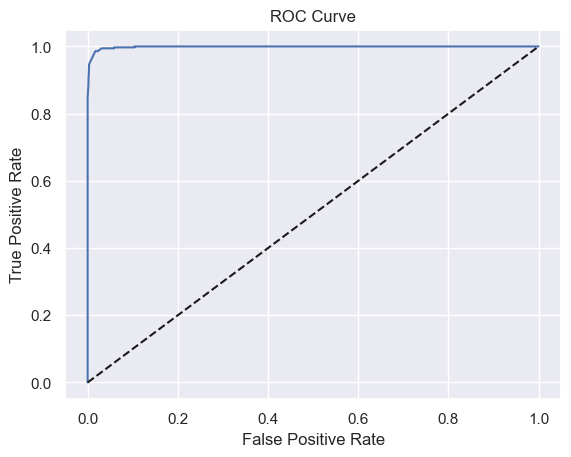

In [78]:
# ROC Curve
plt.plot(fpr, tpr)
# Benchmark (predicting by chance)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

#### Area Under the Curve

- Bad: $ 50 - 60 $ %
- Poor: $ 60 - 70 $ %
- Fair: $ 70 - 80 $ %
- Good: $ 80 - 90 $ %
- Excellent: $ 90 - 100 $ %

In [79]:
AUROC = roc_auc_score(df_actual_predicted_probs['loan_data_targets_test'], 
                                 df_actual_predicted_probs['y_hat_test_proba'])
AUROC # 99.87% - Super accurate

0.9987496512632775

### Evaluation of Model Performance: 
Gini and Kolmogorov-Smirnov

#### Gini Coefficient
Originally used to measure inequality between rich and poor individuals in an economy.
In credit risk modeling, it's used to measure inequality between non-defaulted and defaulted borrowers in a population.

- Measured by plotting the cumulative proportion of defaulted borrowers as a function of the cumulative proportion of all borrowers.
- Borrowers must be in ascending order by estimated probability of being good from the PD model.
- The Gini coefficient is the percentage of the area above the secondary diagonal line enclosed between the concave curve and the secondary diagonal line.
- The greater the area, the better the model.

#### Kolmogorov-Smirnov Coefficient
Shows to what extent the model separates actual good borrowers from actual bad borrowers.
- Measured by considering cumulative distributions of actual good borrowers and actual bad borrowers.
- K-s is the maximum difference between the cumulative distribution functions of good and bad borrowers.

In [80]:
# Sort in descending order of probabilities
df_actual_predicted_probs = df_actual_predicted_probs.sort_values('y_hat_test_proba')
df_actual_predicted_probs.head()

,loan_data_targets_test,y_hat_test_proba,y_hat_test
9718,0,0.000007,0
8031,0,0.000007,0
5871,0,0.000007,0
1866,0,0.000010,0
2279,0,0.000010,0


In [81]:
df_actual_predicted_probs.tail()

,loan_data_targets_test,y_hat_test_proba,y_hat_test
2007,1,0.999097,1
1374,1,0.999097,1
577,1,0.999830,1
95,1,0.999830,1
7033,1,0.999830,1


In [82]:
# Update index to reflect new order
df_actual_predicted_probs = df_actual_predicted_probs.reset_index()
df_actual_predicted_probs.head()

,index,loan_data_targets_test,y_hat_test_proba,y_hat_test
0,9718,0,0.000007,0
1,8031,0,0.000007,0
2,5871,0,0.000007,0
3,1866,0,0.000010,0
4,2279,0,0.000010,0


In [83]:
# Calculate cumulative observations
df_actual_predicted_probs['Cumulative N Population'] = df_actual_predicted_probs.index + 1
df_actual_predicted_probs['Cumulative N Default'] = df_actual_predicted_probs['loan_data_targets_test'].cumsum()
df_actual_predicted_probs['Cumulative N No Default'] = df_actual_predicted_probs['Cumulative N Population'] - df_actual_predicted_probs['loan_data_targets_test'].cumsum()
df_actual_predicted_probs.head()

,index,loan_data_targets_test,y_hat_test_proba,y_hat_test,Cumulative N Population,Cumulative N Default,Cumulative N No Default
0,9718,0,0.000007,0,1,0,1
1,8031,0,0.000007,0,2,0,2
2,5871,0,0.000007,0,3,0,3
3,1866,0,0.000010,0,4,0,4
4,2279,0,0.000010,0,5,0,5


In [84]:
# Calculate cumulative percentages
df_actual_predicted_probs['Cumulative Perc Population'] = df_actual_predicted_probs['Cumulative N Population'] / (df_actual_predicted_probs.shape[0])
df_actual_predicted_probs['Cumulative Perc Default'] = df_actual_predicted_probs['Cumulative N Default'] / df_actual_predicted_probs['Cumulative N Default'].sum()
df_actual_predicted_probs['Cumulative Perc No Default'] = df_actual_predicted_probs['Cumulative N No Default'] / (df_actual_predicted_probs.shape[0] - df_actual_predicted_probs['loan_data_targets_test'].sum())
df_actual_predicted_probs.head()

,index,loan_data_targets_test,y_hat_test_proba,y_hat_test,Cumulative N Population,Cumulative N Default,Cumulative N No Default,Cumulative Perc Population,Cumulative Perc Default,Cumulative Perc No Default
0,9718,0,0.000007,0,1,0,1,0.0005,0.0,0.000609
1,8031,0,0.000007,0,2,0,2,0.0010,0.0,0.001218
2,5871,0,0.000007,0,3,0,3,0.0015,0.0,0.001827
3,1866,0,0.000010,0,4,0,4,0.0020,0.0,0.002436
4,2279,0,0.000010,0,5,0,5,0.0025,0.0,0.003045


Text(0.5, 1.0, 'Gini')

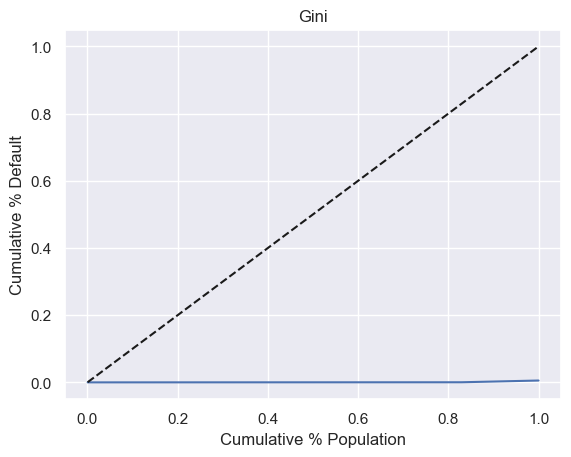

In [85]:
# Plot the Gini Coefficient
plt.plot(df_actual_predicted_probs['Cumulative Perc Population'], df_actual_predicted_probs['Cumulative Perc Default'])
plt.plot(df_actual_predicted_probs['Cumulative Perc Population'], df_actual_predicted_probs['Cumulative Perc Population'], linestyle = '--', color = 'k')
plt.xlabel('Cumulative % Population')
plt.ylabel('Cumulative % Default')
plt.title('Gini')

$$ Gini = AUROC \cdot 2 - 1 $$
$$ AUROC = \frac{Gini + 1}{2} $$

In [86]:
# Calculate Gini Coefficient
Gini = AUROC * 2 - 1
Gini

0.997499302526555

Text(0.5, 1.0, 'Kolmogorov-Smirnov')

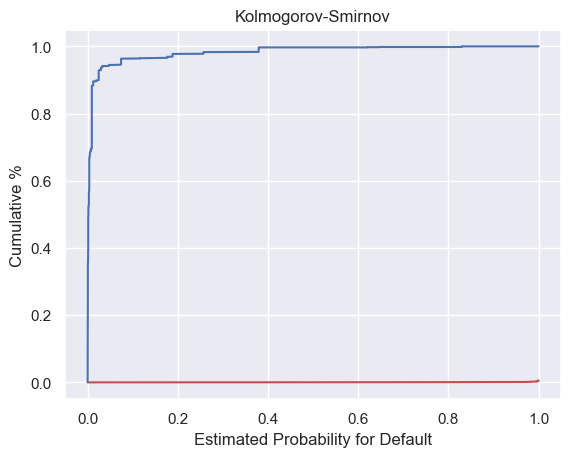

In [87]:
# Plot K-s
plt.plot(df_actual_predicted_probs['y_hat_test_proba'], df_actual_predicted_probs['Cumulative Perc Default'], color = 'r')
plt.plot(df_actual_predicted_probs['y_hat_test_proba'], df_actual_predicted_probs['Cumulative Perc No Default'], color = 'b')
plt.xlabel('Estimated Probability for Default')
plt.ylabel('Cumulative %')
plt.title('Kolmogorov-Smirnov')

In [88]:
# Calculate K-s Coefficient
KS = max(df_actual_predicted_probs['Cumulative Perc Default'] - df_actual_predicted_probs['Cumulative Perc No Default'])
KS # -0.0006090133982947625 Too close to zero. Model does not have satisfactory predictive power.

-0.0006090133982947625

## Applying the PD Model

In [89]:
inputs_test_with_ref_cat.head()

,fico_rating: Poor,fico_rating: Fair,fico_rating: Good,fico_rating: Very Good,fico_rating: Excellent,tenure: 0,tenure: 1,tenure: 2-4,tenure: 5-6,tenure: 7-9,tenure: 10+,clo: 0,clo: 1,clo: 2,clo: 3,clo: 4,clo: 5
757,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
1003,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
8089,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
2967,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
5011,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [90]:
summary_table

,Feature Name,Coefficients,p_values
0,Intercept,-6.152802,NaN
1,fico_rating: Poor,-6.152802,6.558967e-01
2,fico_rating: Fair,-6.152802,9.144731e-01
3,fico_rating: Good,1.299790,8.215672e-01
4,fico_rating: Very Good,0.312789,7.510583e-01
5,tenure: 0,-0.655148,6.176461e-01
6,tenure: 1,-0.948482,3.365625e-01
7,tenure: 2-4,1.534296,6.878842e-01
8,tenure: 5-6,2.834855,7.655227e-01
9,tenure: 7-9,1.166604,2.304695e-01


In [91]:
y_hat_test_proba

array([3.54501968e-04, 9.97583226e-01, 1.22175275e-03, ...,
       7.40626936e-02, 3.54501968e-04, 9.25290690e-03])

In [92]:
ref_categories

['fico_rating: Excellent', 'tenure: 10+', 'clo: 0']

### Calculate individual scores annd create scorecards

Credit worthiness assessments are named after the credit scorecard and called credit scores.

In [93]:
# Include all reference categories
df_ref_categories = pd.DataFrame(ref_categories, columns = ['Feature Name'])
df_ref_categories['Coefficients'] = 0
df_ref_categories['p_values'] = np.nan
df_ref_categories

,Feature Name,Coefficients,p_values
0,fico_rating: Excellent,0,NaN
1,tenure: 10+,0,NaN
2,clo: 0,0,NaN


In [94]:
df_scorecard = pd.concat([summary_table, df_ref_categories])
df_scorecard = df_scorecard.reset_index()
df_scorecard

,index,Feature Name,Coefficients,p_values
0,0,Intercept,-6.152802,NaN
1,1,fico_rating: Poor,-6.152802,6.558967e-01
2,2,fico_rating: Fair,-6.152802,9.144731e-01
3,3,fico_rating: Good,1.299790,8.215672e-01
4,4,fico_rating: Very Good,0.312789,7.510583e-01
5,5,tenure: 0,-0.655148,6.176461e-01
6,6,tenure: 1,-0.948482,3.365625e-01
7,7,tenure: 2-4,1.534296,6.878842e-01
8,8,tenure: 5-6,2.834855,7.655227e-01
9,9,tenure: 7-9,1.166604,2.304695e-01


In [95]:
# Save original feature names
df_scorecard['Original Feature Name'] = df_scorecard['Feature Name'].str.split(':').str[0]
df_scorecard

,index,Feature Name,Coefficients,p_values,Original Feature Name
0,0,Intercept,-6.152802,NaN,Intercept
1,1,fico_rating: Poor,-6.152802,6.558967e-01,fico_rating
2,2,fico_rating: Fair,-6.152802,9.144731e-01,fico_rating
3,3,fico_rating: Good,1.299790,8.215672e-01,fico_rating
4,4,fico_rating: Very Good,0.312789,7.510583e-01,fico_rating
5,5,tenure: 0,-0.655148,6.176461e-01,tenure
6,6,tenure: 1,-0.948482,3.365625e-01,tenure
7,7,tenure: 2-4,1.534296,6.878842e-01,tenure
8,8,tenure: 5-6,2.834855,7.655227e-01,tenure
9,9,tenure: 7-9,1.166604,2.304695e-01,tenure


In [96]:
# Convert regression coefficients into simple scores range(300,850)
min_score = 300
max_score = 850

In [97]:
# Corresponds to no default
min_sum_coef = df_scorecard.groupby('Original Feature Name')['Coefficients'].min().sum()
min_sum_coef

-16.76133730464861

In [98]:
# Corresponds to default
max_sum_coef = df_scorecard.groupby('Original Feature Name')['Coefficients'].max().sum()
max_sum_coef

-2.0181560086455956

$$ variable score = variable coef \frac{(max score - min score)}{(max sum coef - min sum coef)} $$

In [99]:
# Rescale coefficients
df_scorecard['Score - Calculation'] = df_scorecard['Coefficients'] * (max_score - min_score) / (max_sum_coef - min_sum_coef)
df_scorecard

,index,Feature Name,Coefficients,p_values,Original Feature Name,Score - Calculation
0,0,Intercept,-6.152802,NaN,Intercept,-229.532609
1,1,fico_rating: Poor,-6.152802,6.558967e-01,fico_rating,-229.532609
2,2,fico_rating: Fair,-6.152802,9.144731e-01,fico_rating,-229.532609
3,3,fico_rating: Good,1.299790,8.215672e-01,fico_rating,48.489170
4,4,fico_rating: Very Good,0.312789,7.510583e-01,fico_rating,11.668724
5,5,tenure: 0,-0.655148,6.176461e-01,tenure,-24.440532
6,6,tenure: 1,-0.948482,3.365625e-01,tenure,-35.383472
7,7,tenure: 2-4,1.534296,6.878842e-01,tenure,57.237502
8,8,tenure: 5-6,2.834855,7.655227e-01,tenure,105.755360
9,9,tenure: 7-9,1.166604,2.304695e-01,tenure,43.520596


$$ intercept score = \frac{(intercept coef - min score)}{(max sum coef - min sum coef)} (max score - min score) + min_score  $$

The score corresponding to the intercept is very close to the maximum score.

In [100]:
df_scorecard['Score - Calculation'][0] = ((df_scorecard['Coefficients'][0] - min_sum_coef) / (max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score
df_scorecard

/var/folders/nk/lc4kg2ys4nxfxb02cx2vc30m0000gn/T/ipykernel_4633/1263832758.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scorecard['Score - Calculation'][0] = ((df_scorecard['Coefficients'][0] - min_sum_coef) / (max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score


,index,Feature Name,Coefficients,p_values,Original Feature Name,Score - Calculation
0,0,Intercept,-6.152802,NaN,Intercept,695.755471
1,1,fico_rating: Poor,-6.152802,6.558967e-01,fico_rating,-229.532609
2,2,fico_rating: Fair,-6.152802,9.144731e-01,fico_rating,-229.532609
3,3,fico_rating: Good,1.299790,8.215672e-01,fico_rating,48.489170
4,4,fico_rating: Very Good,0.312789,7.510583e-01,fico_rating,11.668724
5,5,tenure: 0,-0.655148,6.176461e-01,tenure,-24.440532
6,6,tenure: 1,-0.948482,3.365625e-01,tenure,-35.383472
7,7,tenure: 2-4,1.534296,6.878842e-01,tenure,57.237502
8,8,tenure: 5-6,2.834855,7.655227e-01,tenure,105.755360
9,9,tenure: 7-9,1.166604,2.304695e-01,tenure,43.520596


In [101]:
# Round credit scores for user friendly results
df_scorecard['Score - Preliminary'] = df_scorecard['Score - Calculation'].round()
df_scorecard

,index,Feature Name,Coefficients,p_values,Original Feature Name,Score - Calculation,Score - Preliminary
0,0,Intercept,-6.152802,NaN,Intercept,695.755471,696.0
1,1,fico_rating: Poor,-6.152802,6.558967e-01,fico_rating,-229.532609,-230.0
2,2,fico_rating: Fair,-6.152802,9.144731e-01,fico_rating,-229.532609,-230.0
3,3,fico_rating: Good,1.299790,8.215672e-01,fico_rating,48.489170,48.0
4,4,fico_rating: Very Good,0.312789,7.510583e-01,fico_rating,11.668724,12.0
5,5,tenure: 0,-0.655148,6.176461e-01,tenure,-24.440532,-24.0
6,6,tenure: 1,-0.948482,3.365625e-01,tenure,-35.383472,-35.0
7,7,tenure: 2-4,1.534296,6.878842e-01,tenure,57.237502,57.0
8,8,tenure: 5-6,2.834855,7.655227e-01,tenure,105.755360,106.0
9,9,tenure: 7-9,1.166604,2.304695e-01,tenure,43.520596,44.0


In [102]:
# Review whether minimum and maximum possible scores are equal to the desired minimum and maximum scores
min_sum_score_prel = df_scorecard.groupby('Original Feature Name')['Score - Preliminary'].min().sum()
max_sum_score_prel = df_scorecard.groupby('Original Feature Name')['Score - Preliminary'].max().sum()
max_sum_score_prel, min_sum_score_prel

(850.0, 300.0)

In [103]:
# Ensure that rounding of score doesn't result in a higher maximum than desired
# Need to subtract one from the score of every dummy category that yields maximum scores for each original independent variable
# It's best practice to subtract one from the variable that was rounded the most
df_scorecard['Difference'] = df_scorecard['Score - Preliminary'] - df_scorecard['Score - Calculation']
df_scorecard

,index,Feature Name,Coefficients,p_values,Original Feature Name,Score - Calculation,Score - Preliminary,Difference
0,0,Intercept,-6.152802,NaN,Intercept,695.755471,696.0,0.244529
1,1,fico_rating: Poor,-6.152802,6.558967e-01,fico_rating,-229.532609,-230.0,-0.467391
2,2,fico_rating: Fair,-6.152802,9.144731e-01,fico_rating,-229.532609,-230.0,-0.467391
3,3,fico_rating: Good,1.299790,8.215672e-01,fico_rating,48.489170,48.0,-0.489170
4,4,fico_rating: Very Good,0.312789,7.510583e-01,fico_rating,11.668724,12.0,0.331276
5,5,tenure: 0,-0.655148,6.176461e-01,tenure,-24.440532,-24.0,0.440532
6,6,tenure: 1,-0.948482,3.365625e-01,tenure,-35.383472,-35.0,0.383472
7,7,tenure: 2-4,1.534296,6.878842e-01,tenure,57.237502,57.0,-0.237502
8,8,tenure: 5-6,2.834855,7.655227e-01,tenure,105.755360,106.0,0.244640
9,9,tenure: 7-9,1.166604,2.304695e-01,tenure,43.520596,44.0,0.479404


In [104]:
# Create new variable score final equal to score preliminary
df_scorecard['Score - Final'] = df_scorecard['Score - Preliminary']
# Ignoring this case since our possible maximum score actually matches our desired maximum score
# Leave all other scores the same except the one with the highest difference between the preliminary score and the calculation score
###df_scorecard['Score - Final'][3] = 47
df_scorecard

,index,Feature Name,Coefficients,p_values,Original Feature Name,Score - Calculation,Score - Preliminary,Difference,Score - Final
0,0,Intercept,-6.152802,NaN,Intercept,695.755471,696.0,0.244529,696.0
1,1,fico_rating: Poor,-6.152802,6.558967e-01,fico_rating,-229.532609,-230.0,-0.467391,-230.0
2,2,fico_rating: Fair,-6.152802,9.144731e-01,fico_rating,-229.532609,-230.0,-0.467391,-230.0
3,3,fico_rating: Good,1.299790,8.215672e-01,fico_rating,48.489170,48.0,-0.489170,48.0
4,4,fico_rating: Very Good,0.312789,7.510583e-01,fico_rating,11.668724,12.0,0.331276,12.0
5,5,tenure: 0,-0.655148,6.176461e-01,tenure,-24.440532,-24.0,0.440532,-24.0
6,6,tenure: 1,-0.948482,3.365625e-01,tenure,-35.383472,-35.0,0.383472,-35.0
7,7,tenure: 2-4,1.534296,6.878842e-01,tenure,57.237502,57.0,-0.237502,57.0
8,8,tenure: 5-6,2.834855,7.655227e-01,tenure,105.755360,106.0,0.244640,106.0
9,9,tenure: 7-9,1.166604,2.304695e-01,tenure,43.520596,44.0,0.479404,44.0


In [105]:
# Again, Review whether minimum and maximum possible scores are equal to the desired minimum and maximum scores
min_sum_score_prel = df_scorecard.groupby('Original Feature Name')['Score - Final'].min().sum()
max_sum_score_prel = df_scorecard.groupby('Original Feature Name')['Score - Final'].max().sum()
max_sum_score_prel, min_sum_score_prel

(850.0, 300.0)

#### Calculating credit score for individual borrower

In [106]:
# Sum the dummy coefficients of each category
inputs_test_with_ref_cat.head()

,fico_rating: Poor,fico_rating: Fair,fico_rating: Good,fico_rating: Very Good,fico_rating: Excellent,tenure: 0,tenure: 1,tenure: 2-4,tenure: 5-6,tenure: 7-9,tenure: 10+,clo: 0,clo: 1,clo: 2,clo: 3,clo: 4,clo: 5
757,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
1003,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
8089,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
2967,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
5011,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [107]:
df_scorecard

,index,Feature Name,Coefficients,p_values,Original Feature Name,Score - Calculation,Score - Preliminary,Difference,Score - Final
0,0,Intercept,-6.152802,NaN,Intercept,695.755471,696.0,0.244529,696.0
1,1,fico_rating: Poor,-6.152802,6.558967e-01,fico_rating,-229.532609,-230.0,-0.467391,-230.0
2,2,fico_rating: Fair,-6.152802,9.144731e-01,fico_rating,-229.532609,-230.0,-0.467391,-230.0
3,3,fico_rating: Good,1.299790,8.215672e-01,fico_rating,48.489170,48.0,-0.489170,48.0
4,4,fico_rating: Very Good,0.312789,7.510583e-01,fico_rating,11.668724,12.0,0.331276,12.0
5,5,tenure: 0,-0.655148,6.176461e-01,tenure,-24.440532,-24.0,0.440532,-24.0
6,6,tenure: 1,-0.948482,3.365625e-01,tenure,-35.383472,-35.0,0.383472,-35.0
7,7,tenure: 2-4,1.534296,6.878842e-01,tenure,57.237502,57.0,-0.237502,57.0
8,8,tenure: 5-6,2.834855,7.655227e-01,tenure,105.755360,106.0,0.244640,106.0
9,9,tenure: 7-9,1.166604,2.304695e-01,tenure,43.520596,44.0,0.479404,44.0


In [108]:
inputs_test_with_ref_cat_w_intercept = inputs_test_with_ref_cat

In [109]:
# Get the intercept score for all observations
inputs_test_with_ref_cat_w_intercept.insert(0, 'Intercept', 1)

In [110]:
inputs_test_with_ref_cat_w_intercept.head()

,Intercept,fico_rating: Poor,fico_rating: Fair,fico_rating: Good,fico_rating: Very Good,fico_rating: Excellent,tenure: 0,tenure: 1,tenure: 2-4,tenure: 5-6,tenure: 7-9,tenure: 10+,clo: 0,clo: 1,clo: 2,clo: 3,clo: 4,clo: 5
757,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
1003,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
8089,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
2967,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
5011,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [111]:
# Ensure that columns are in the same order as df_scorecard table
inputs_test_with_ref_cat_w_intercept = inputs_test_with_ref_cat_w_intercept[df_scorecard['Feature Name'].values]
inputs_test_with_ref_cat_w_intercept.head()

,Intercept,fico_rating: Poor,fico_rating: Fair,fico_rating: Good,fico_rating: Very Good,tenure: 0,tenure: 1,tenure: 2-4,tenure: 5-6,tenure: 7-9,clo: 1,clo: 2,clo: 3,clo: 4,clo: 5,fico_rating: Excellent,tenure: 10+,clo: 0
757,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
1003,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
8089,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2967,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
5011,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0


In [112]:
scorecard_scores = df_scorecard['Score - Final']
scorecard_scores

0     696.0
1    -230.0
2    -230.0
3      48.0
4      12.0
5     -24.0
6     -35.0
7      57.0
8     106.0
9      44.0
10    -32.0
11   -131.0
12     -1.0
13      0.0
14      0.0
15      0.0
16      0.0
17      0.0
Name: Score - Final, dtype: float64

In [113]:
# Check dimensional compatibility
inputs_test_with_ref_cat_w_intercept.shape

(2000, 18)

In [114]:
scorecard_scores.shape

(18,)

In [115]:
# Reshape 
scorecard_scores = scorecard_scores.values.reshape(18,1)
scorecard_scores

array([[ 696.],
       [-230.],
       [-230.],
       [  48.],
       [  12.],
       [ -24.],
       [ -35.],
       [  57.],
       [ 106.],
       [  44.],
       [ -32.],
       [-131.],
       [  -1.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.]])

In [116]:
# Multiply each row the test data by the column with scores then sum the products
y_scores = inputs_test_with_ref_cat_w_intercept.dot(scorecard_scores)
y_scores.head()

,0
757,540.0
1003,523.0
8089,572.0
2967,522.0
5011,788.0


### Calculate Probability of Default (PD)

$$ sum_of_coef_from_score = \frac{total_score - min_score}{max_score - min_score} (max_sum_coef - min_sum_coef) + min_sum_coef $$

In [117]:
sum_coef_from_score = ((y_scores - min_score) / (max_score - min_score)) * (max_sum_coef - min_sum_coef) + min_sum_coef
sum_coef_from_score

,0
757,-10.327949
1003,-10.783647
8089,-9.470164
2967,-10.810453
5011,-3.680115
495,-9.470164
9314,-2.018156
6108,-10.327949
769,-10.783647
8731,-2.018156


In [118]:
# Raise to exponent of coefficients
y_hat_proba_from_score = np.exp(sum_coef_from_score) / (np.exp(sum_coef_from_score) + 1)
y_hat_proba_from_score.head()

,0
757,0.000033
1003,0.000021
8089,0.000077
2967,0.000020
5011,0.024600


In [119]:
# Compare with the probabilities of non-default
y_hat_test_proba[0: 5]

# These are not an exact match due to rounding

array([3.54501968e-04, 9.97583226e-01, 1.22175275e-03, 3.79147117e-01,
       5.93982481e-01])

### Set Cut-Off Threshold(s)

A cut-off determines which loan applications will be granted and which will be rejected.

##### Cut-off Rate
1. Predetermines the total number of borrowers that will be approved and rejected.
2. Impacts the quality of loans.

Trade-Offs:
- Too many loans = Lower Loan Quality
- High-quality loans only = limited number of loans (limited ability to make a profit)


Use ROC curve to determine cut-off taking confusion matrix into account.

#### Receiver Operating Curve (ROC)

In [120]:
# FPR - False Positive Rate, TPR - True Positive Rate
fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['loan_data_targets_test'], 
                                 df_actual_predicted_probs['y_hat_test_proba'])

Text(0.5, 1.0, 'ROC Curve')

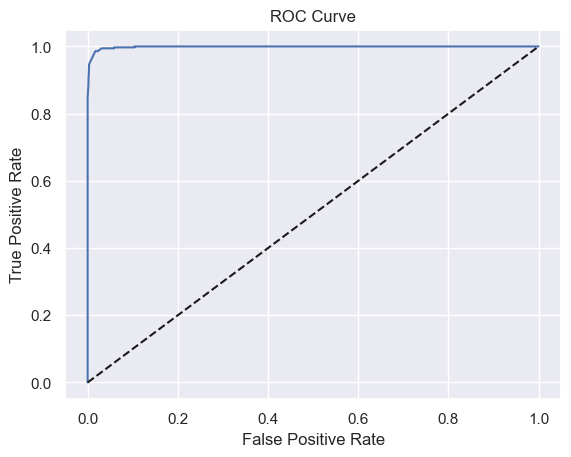

In [121]:
# ROC Curve
plt.plot(fpr, tpr)
# Benchmark (predicting by chance)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

#### Area Under the Curve

- Bad: $ 50 - 60 $ %
- Poor: $ 60 - 70 $ %
- Fair: $ 70 - 80 $ %
- Good: $ 80 - 90 $ %
- Excellent: $ 90 - 100 $ %

In [122]:
AUROC = roc_auc_score(df_actual_predicted_probs['loan_data_targets_test'], 
                                 df_actual_predicted_probs['y_hat_test_proba'])
AUROC # 99.87% - Super accurate

0.9987496512632775

In [123]:
thresholds

array([           inf, 9.99829711e-01, 9.99097314e-01, 9.98798338e-01,
       9.98103323e-01, 9.97583226e-01, 9.96699097e-01, 9.94930461e-01,
       9.93658250e-01, 9.93149147e-01, 9.93072804e-01, 9.90020028e-01,
       9.86754451e-01, 9.81839469e-01, 9.81639427e-01, 9.73681560e-01,
       9.53536642e-01, 9.33525578e-01, 9.28536322e-01, 8.28933806e-01,
       7.93985209e-01, 6.47809940e-01, 6.20850709e-01, 5.93982481e-01,
       4.68799131e-01, 3.79147117e-01, 2.56742176e-01, 1.88187103e-01,
       1.76598647e-01, 1.50627005e-01, 1.15921363e-01, 7.40626936e-02,
       6.73788724e-02, 4.72044134e-02, 4.60845912e-02, 3.23486253e-02,
       2.94674713e-02, 2.44902371e-02, 2.44304518e-02, 2.21414101e-02,
       1.84589164e-02, 1.76983537e-02, 1.23139659e-02, 9.25290690e-03,
       7.20759037e-03, 6.78541965e-03, 5.66957775e-03, 5.09706201e-03,
       4.71024419e-03, 4.35951646e-03, 3.89750574e-03, 3.53259084e-03,
       3.51690204e-03, 3.26926389e-03, 2.70022214e-03, 2.63681717e-03,
      

In [124]:
thresholds.shape

(85,)

In [125]:
df_cutoffs = pd.concat([pd.DataFrame(thresholds), pd.DataFrame(fpr), pd.DataFrame(tpr)], axis = 1)
df_cutoffs.columns = ['thresholds','fpr','tpr']
df_cutoffs.head()

,thresholds,fpr,tpr
0,inf,0.0,0.000000
1,0.999830,0.0,0.008380
2,0.999097,0.0,0.170391
3,0.998798,0.0,0.173184
4,0.998103,0.0,0.189944


In [126]:
# The first row is not very informative. Let's set it to one as this is the limit of probabilities.
df_cutoffs['thresholds'][0] = 1 - 1/ np.power(10, 16)

$$ score_from_prob = (ln\frac{prob_good}{1 - prob_good} - min_sum_coef) \frac{(max_score - min_score)}{(max_sum_coef - min_sum_coef)}  + min_score $$

In [127]:
# Use scores to set cutoffs
df_cutoffs['Score'] = ((np.log(df_cutoffs['thresholds'] / (1 - df_cutoffs['thresholds'])) - min_sum_coef) * ((max_score - min_score) / (max_sum_coef - min_sum_coef)) + min_score)
df_cutoffs.head()

,thresholds,fpr,tpr,Score
0,1.000000,0.0,0.000000,2295.768433
1,0.999830,0.0,0.008380,1249.018245
2,0.999097,0.0,0.170391,1186.770167
3,0.998798,0.0,0.173184,1176.086455
4,0.998103,0.0,0.189944,1159.034402


In [132]:
# First score is very high and out of range. Set it as the max_score.
df_cutoffs['Score'].where(df_cutoffs['Score'] <= 850, 850, inplace = True)
df_cutoffs.head()

,thresholds,fpr,tpr,Score
0,1.000000,0.0,0.000000,850.0
1,0.999830,0.0,0.008380,850.0
2,0.999097,0.0,0.170391,850.0
3,0.998798,0.0,0.173184,850.0
4,0.998103,0.0,0.189944,850.0


In [133]:
df_cutoffs.tail()

,thresholds,fpr,tpr,Score
80,0.000025,0.977467,1.0,530.391875
81,0.000025,0.980512,1.0,529.503072
82,0.000018,0.981121,1.0,518.728382
83,0.000010,0.998173,1.0,494.255519
84,0.000007,1.000000,1.0,483.311705


In [134]:
df_cutoffs.head()

,thresholds,fpr,tpr,Score
0,1.000000,0.0,0.000000,850.0
1,0.999830,0.0,0.008380,850.0
2,0.999097,0.0,0.170391,850.0
3,0.998798,0.0,0.173184,850.0
4,0.998103,0.0,0.189944,850.0


### Compare Approval and Rejection rates for each possible cutoff

In [135]:
# Create function to calculate approval rate
def n_approved(p):
    return np.where(df_actual_predicted_probs['y_hat_test_proba'] >= p, 1, 0).sum()

In [136]:
df_cutoffs['N Approved'] = df_cutoffs['thresholds'].apply(n_approved)
df_cutoffs['N Rejected'] = df_actual_predicted_probs['y_hat_test_proba'].shape[0] - df_cutoffs['N Approved']
df_cutoffs['Approval Rate'] = df_cutoffs['N Approved'] / df_actual_predicted_probs['y_hat_test_proba'].shape[0]
df_cutoffs['Rejection Rate'] = 1 - df_cutoffs['Approval Rate']

In [137]:
df_cutoffs.head()

,thresholds,fpr,tpr,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
0,1.000000,0.0,0.000000,850.0,0,2000,0.0000,1.0000
1,0.999830,0.0,0.008380,850.0,3,1997,0.0015,0.9985
2,0.999097,0.0,0.170391,850.0,61,1939,0.0305,0.9695
3,0.998798,0.0,0.173184,850.0,62,1938,0.0310,0.9690
4,0.998103,0.0,0.189944,850.0,68,1932,0.0340,0.9660


In [138]:
df_cutoffs.tail()

,thresholds,fpr,tpr,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
80,0.000025,0.977467,1.0,530.391875,1963,37,0.9815,0.0185
81,0.000025,0.980512,1.0,529.503072,1968,32,0.9840,0.0160
82,0.000018,0.981121,1.0,518.728382,1969,31,0.9845,0.0155
83,0.000010,0.998173,1.0,494.255519,1997,3,0.9985,0.0015
84,0.000007,1.000000,1.0,483.311705,2000,0,1.0000,0.0000


In [139]:
df_cutoffs

,thresholds,fpr,tpr,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
0,1.000000,0.000000,0.000000,850.000000,0,2000,0.0000,1.0000
1,0.999830,0.000000,0.008380,850.000000,3,1997,0.0015,0.9985
2,0.999097,0.000000,0.170391,850.000000,61,1939,0.0305,0.9695
3,0.998798,0.000000,0.173184,850.000000,62,1938,0.0310,0.9690
4,0.998103,0.000000,0.189944,850.000000,68,1932,0.0340,0.9660
5,0.997583,0.000000,0.488827,850.000000,175,1825,0.0875,0.9125
6,0.996699,0.000000,0.491620,850.000000,176,1824,0.0880,0.9120
7,0.994930,0.000000,0.505587,850.000000,181,1819,0.0905,0.9095
8,0.993658,0.000000,0.544693,850.000000,195,1805,0.0975,0.9025
9,0.993149,0.000000,0.589385,850.000000,211,1789,0.1055,0.8945


In [140]:
# Export
# inputs_train_with_ref_cat.to_csv('inputs_train_with_ref_cat.csv')
# df_scorecard.to_csv('df_scorecard.csv')